<a href="https://colab.research.google.com/github/KristinaBorovikS/ML/blob/main/HW4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
!pip install UMAP
import plotly.express as px
from sklearn.datasets import load_digits
from umap import UMAP



import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LinearRegression
train = pd.read_json(r'/train.json')
test = pd.read_json(r'/test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())

count =0
count_in=0
df_new=df['ingredients']

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])

vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]

X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)



X_train_vectorized_m=X_train_vectorized[:1000]
print ('-------------------------------------------------------------------------')
print(X_train_vectorized_m.getnnz())
umap_2d = UMAP(random_state=0)
umap_2d.fit(X_train_vectorized_m)

projections = umap_2d.transform(X_train_vectorized_m)

fig = px.scatter(
    projections, x=0, y=1,
    color=  df['cuisine'].head(1000),
    color_discrete_sequence=["red", "orange", "green","blue","black","yellow","olive","cyan","maroon","purple","grey","teal","violet","pink","magenta"
                             ,"tan","indigo","coral","lavender","fuchsia"],
 labels={'color': 'cuisine'}
)

fig.show()

umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_3d = umap_3d.fit_transform(X_train_vectorized_m)


fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color= df['cuisine'].head(1000), labels={'color': 'cuisine'},
    color_discrete_sequence=["red", "orange", "green", "blue", "black", "yellow", "olive", "cyan", "maroon", "purple",
                             "grey", "teal", "violet", "pink", "magenta"
        , "tan", "indigo", "coral", "lavender", "fuchsia"]
)
fig_3d.update_traces(marker_size=5)

fig_3d.show()










ImportError: cannot import name 'UMAP' from 'umap' (/usr/local/lib/python3.11/dist-packages/umap/__init__.py)

In [29]:
!pip install --quiet optuna

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_california_housing


from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


train = pd.read_json(r'/train.json')
test = pd.read_json(r'/test.json')

df=train

print(df.head())
print(df.info())
print(df['cuisine'].value_counts())
df_new=df['ingredients']
print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])
vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


def objective(trial):
    X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2,
                                                      random_state=42)
    X_val_vectorized = vectorizer.transform(X_val)

    from sklearn.neighbors import KNeighborsClassifier
    n_neighbors = trial.suggest_int("n_neighbors", 2, 15)
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train_vectorized, df['cuisine'])

    val_predictions = model.predict(X_val_vectorized)

    val_losses = model.score(X_val_vectorized, y_val)
    accuracy = accuracy_score(y_val, val_predictions)
    return accuracy


pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=10)

print("Best hyperparameters:", study.best_params)
print("Best value:", study.best_value)

import optuna.visualization as vis


fig1=vis.plot_optimization_history(study)
fig1.show()
fig2=vis.plot_param_importances(study)
fig2.show()
fig3=vis.plot_slice(study)
fig3.show()

X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2,
                                                      random_state=42)
X_val_vectorized = vectorizer.transform(X_val)

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=study.best_params['n_neighbors'])
model.fit(X_train_vectorized, df['cuisine'])
val_predictions = model.predict(X_val_vectorized)
val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

[I 2025-06-08 08:18:35,221] A new study created in memory with name: no-name-2c8a7e34-6ab0-4e83-9b9e-a2371fc5016a
[I 2025-06-08 08:19:13,088] Trial 0 finished with value: 0.7130106851037084 and parameters: {'n_neighbors': 12}. Best is trial 0 with value: 0.7130106851037084.
[I 2025-06-08 08:19:49,685] Trial 1 finished with value: 0.71024512884978 and parameters: {'n_neighbors': 13}. Best is trial 0 with value: 0.7130106851037084.
[I 2025-06-08 08:20:26,645] Trial 2 finished with value: 0.7216844751728473 and parameters: {'n_neighbors': 10}. Best is trial 2 with value: 0.7216844751728473.
[I 2025-06-08 08:21:03,198] Trial 3 finished with value: 0.7175361407919547 and parameters: {'n_neighbors': 11}. Best is trial 2 with value: 0.7216844751728473.
[I 2025-06-08 08:21:38,610] Trial 4 finished with value: 0.7777498428661219 and parameters: {'n_neighbors': 4}. Best is trial 4 with value: 0.7777498428661219.
[I 2025-06-08 08:22:15,013] Trial 5 finished with value: 0.7489629164047769 and para

Best hyperparameters: {'n_neighbors': 4}
Best value: 0.7777498428661219


Validation Loss: 0.22
Accuracy Score gradbusting: 0.78

Classification Report:
              precision    recall  f1-score   support

   brazilian       0.50      0.88      0.64        84
     british       0.54      0.66      0.60       157
cajun_creole       0.73      0.78      0.75       328
     chinese       0.80      0.90      0.85       510
    filipino       0.55      0.76      0.64       136
      french       0.62      0.75      0.68       550
       greek       0.73      0.73      0.73       249
      indian       0.82      0.84      0.83       602
       irish       0.65      0.60      0.62       151
     italian       0.80      0.88      0.84      1567
    jamaican       0.85      0.58      0.69        91
    japanese       0.81      0.67      0.74       284
      korean       0.84      0.77      0.80       166
     mexican       0.88      0.86      0.87      1336
    moroccan       0.89      0.58      0.71       166
     russian       0.69      0.40      0.51        89
 s

In [26]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_california_housing


from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


train = pd.read_json(r'/train.json')
test = pd.read_json(r'/test.json')

df=train
print(df.head())
print(df.info())
print(df['cuisine'].value_counts())
df_new=df['ingredients']
print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])
vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


def objective(trial):
    X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2,
                                                      random_state=42)
    X_val_vectorized = vectorizer.transform(X_val)

    from sklearn.ensemble import ExtraTreesClassifier
    n_estimators = trial.suggest_int("n_estimators", 100, 200)
    max_depth = trial.suggest_int("max_depth", 25,30)
    model = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=0)
    model.fit(X_train_vectorized, df['cuisine'])

    val_predictions = model.predict(X_val_vectorized)

    val_losses = model.score(X_val_vectorized, y_val)
    accuracy = accuracy_score(y_val, val_predictions)
    return accuracy


pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=20)

print("Best hyperparameters:", study.best_params)
print("Best value:", study.best_value)

import optuna.visualization as vis


fig1=vis.plot_optimization_history(study)
fig1.show()
fig2=vis.plot_param_importances(study)
fig2.show()
fig3=vis.plot_slice(study)
fig3.show()


X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2,
                                                      random_state=42)
X_val_vectorized = vectorizer.transform(X_val)

from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(n_estimators=study.best_params['n_estimators'], max_depth=study.best_params['max_depth'], random_state=0)
model.fit(X_train_vectorized, df['cuisine'])
val_predictions = model.predict(X_val_vectorized)
val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()






      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

[I 2025-06-08 07:21:22,973] A new study created in memory with name: no-name-172336fe-fb7f-4b69-b323-52a2d7ccc043
[I 2025-06-08 07:21:59,247] Trial 0 finished with value: 0.7974858579509743 and parameters: {'n_estimators': 112, 'max_depth': 30}. Best is trial 0 with value: 0.7974858579509743.
[I 2025-06-08 07:22:28,548] Trial 1 finished with value: 0.7416719044626021 and parameters: {'n_estimators': 112, 'max_depth': 26}. Best is trial 0 with value: 0.7974858579509743.
[I 2025-06-08 07:23:06,772] Trial 2 finished with value: 0.7294783155248271 and parameters: {'n_estimators': 165, 'max_depth': 25}. Best is trial 0 with value: 0.7974858579509743.
[I 2025-06-08 07:23:55,206] Trial 3 finished with value: 0.7316153362664991 and parameters: {'n_estimators': 196, 'max_depth': 25}. Best is trial 0 with value: 0.7974858579509743.
[I 2025-06-08 07:24:49,040] Trial 4 finished with value: 0.7744814582023885 and parameters: {'n_estimators': 190, 'max_depth': 28}. Best is trial 0 with value: 0.7974

Best hyperparameters: {'n_estimators': 179, 'max_depth': 30}
Best value: 0.8005028284098051


Validation Loss: 0.20
Accuracy Score gradbusting: 0.80

Classification Report:
              precision    recall  f1-score   support

   brazilian       1.00      0.48      0.65        84
     british       1.00      0.27      0.42       157
cajun_creole       1.00      0.76      0.86       328
     chinese       0.85      0.93      0.89       510
    filipino       1.00      0.28      0.44       136
      french       0.98      0.48      0.64       550
       greek       0.99      0.57      0.73       249
      indian       0.97      0.91      0.94       602
       irish       1.00      0.28      0.44       151
     italian       0.60      0.99      0.75      1567
    jamaican       1.00      0.57      0.73        91
    japanese       0.99      0.75      0.85       284
      korean       0.99      0.73      0.84       166
     mexican       0.91      0.95      0.93      1336
    moroccan       0.99      0.73      0.84       166
     russian       1.00      0.34      0.50        89
 s

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 3.5 MB/s eta 0:00:00
Validation Loss: 0.22
Accuracy Score gradbusting: 0.78

Classification Report:
              precision    recall  f1-score   support

   brazilian       0.83      0.54      0.65        84
     british       0.82      0.39      0.53       157
cajun_creole       0.83      0.69      0.75       328
     chinese       0.76      0.87      0.81       510
    filipino       0.76      0.45      0.56       136
      french       0.65      0.63      0.64       550
       greek       0.83      0.66      0.73       249
      indian       0.85      0.87      0.86       602
       irish       0.72      0.46      0.56       151
     italian       0.76      0.92      0.84      1567
    jamaican       0.92      0.59      0.72        91
    japanese       0.86      0.68      0.76       284
      korean       0.90      0.69      0.78       166
     mexican       0.88      0.93      0.90      1336
    moroccan       0.90      0.7

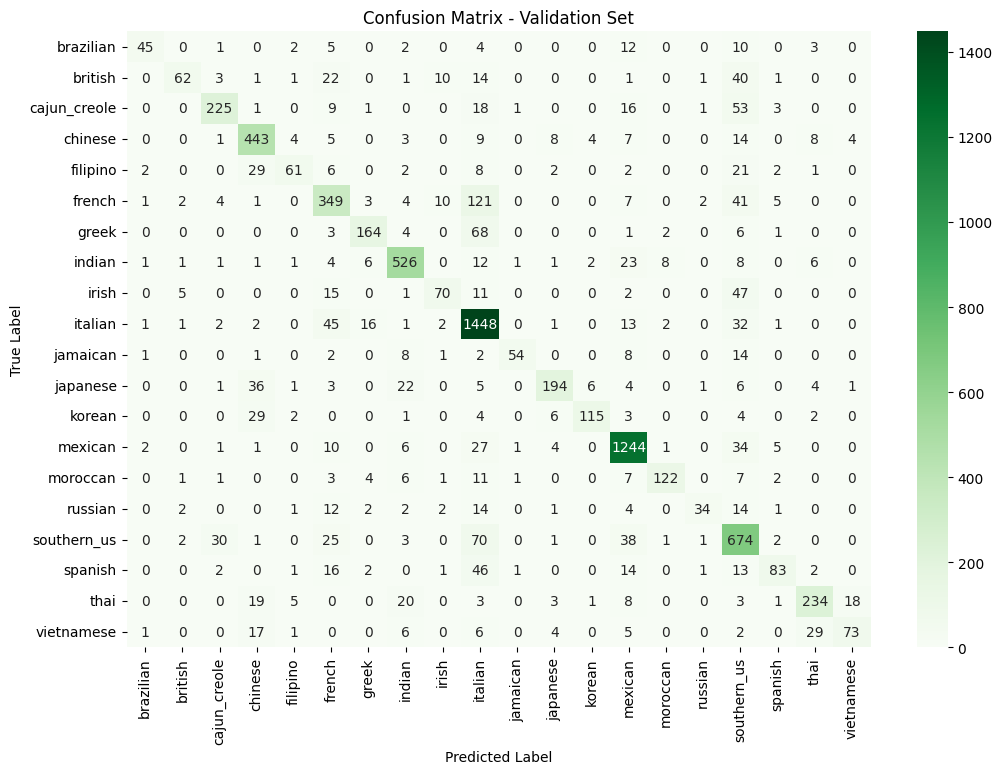

In [27]:
!pip install catboost
import catboost as cb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score




combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])
vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]
X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)


from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=0)
model.fit(X_train_vectorized, df['cuisine'])

val_predictions = model.predict(X_val_vectorized)

val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")

# Print the confusion matrix and classification report for the validation set
conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning:

The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning:

The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning:

The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning:

The covariance matrix of class 3 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:102

Validation Loss: 0.61
Accuracy Score gradbusting: 0.39

Classification Report:
              precision    recall  f1-score   support

   brazilian       0.00      0.00      0.00        84
     british       0.00      0.00      0.00       157
cajun_creole       0.00      0.00      0.00       328
     chinese       0.00      0.00      0.00       510
    filipino       0.00      0.00      0.00       136
      french       0.00      0.00      0.00       550
       greek       0.00      0.00      0.00       249
      indian       0.00      0.00      0.00       602
       irish       0.00      0.00      0.00       151
     italian       0.43      0.88      0.58      1567
    jamaican       0.00      0.00      0.00        91
    japanese       0.00      0.00      0.00       284
      korean       0.00      0.00      0.00       166
     mexican       0.47      0.83      0.60      1336
    moroccan       0.00      0.00      0.00       166
     russian       0.00      0.00      0.00        89
 s

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



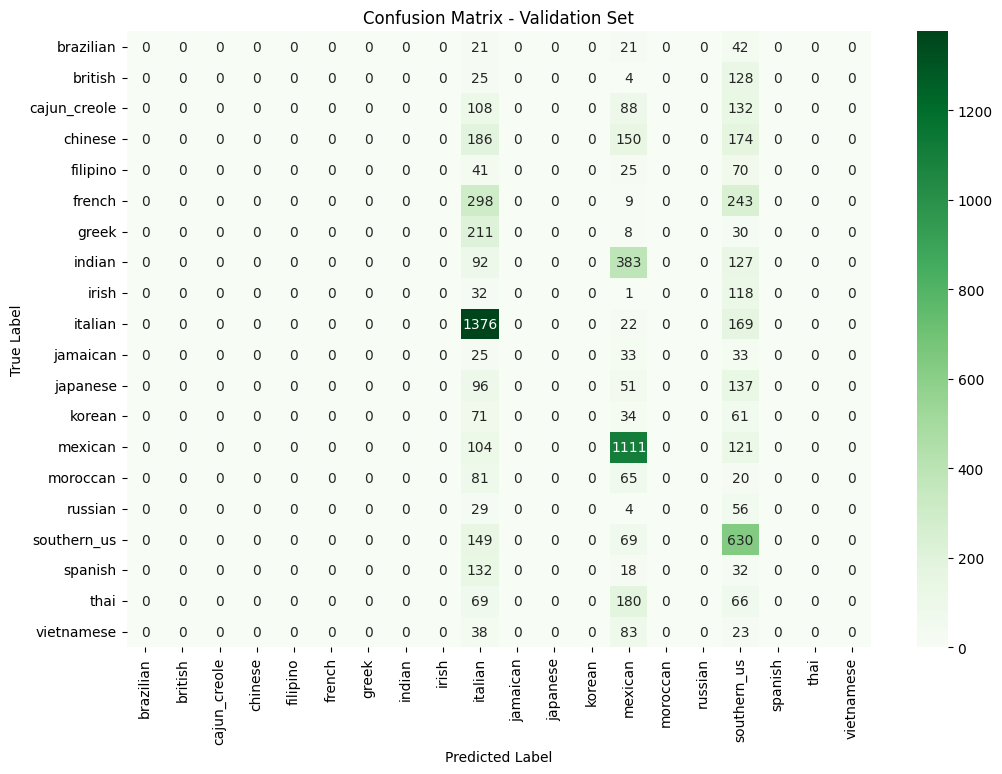

In [25]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight



train = pd.read_json(r'/train.json')
test = pd.read_json(r'/test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())


df_new=df['ingredients']

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])
vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)

# Train a Multinomial Naive Bayes classifier on the training data
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model = QuadraticDiscriminantAnalysis(reg_param=0.7)
model.fit(X_train_vectorized.toarray(), df['cuisine'])

val_predictions = model.predict(X_val_vectorized.toarray())


val_losses = model.score(X_val_vectorized.toarray(), y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



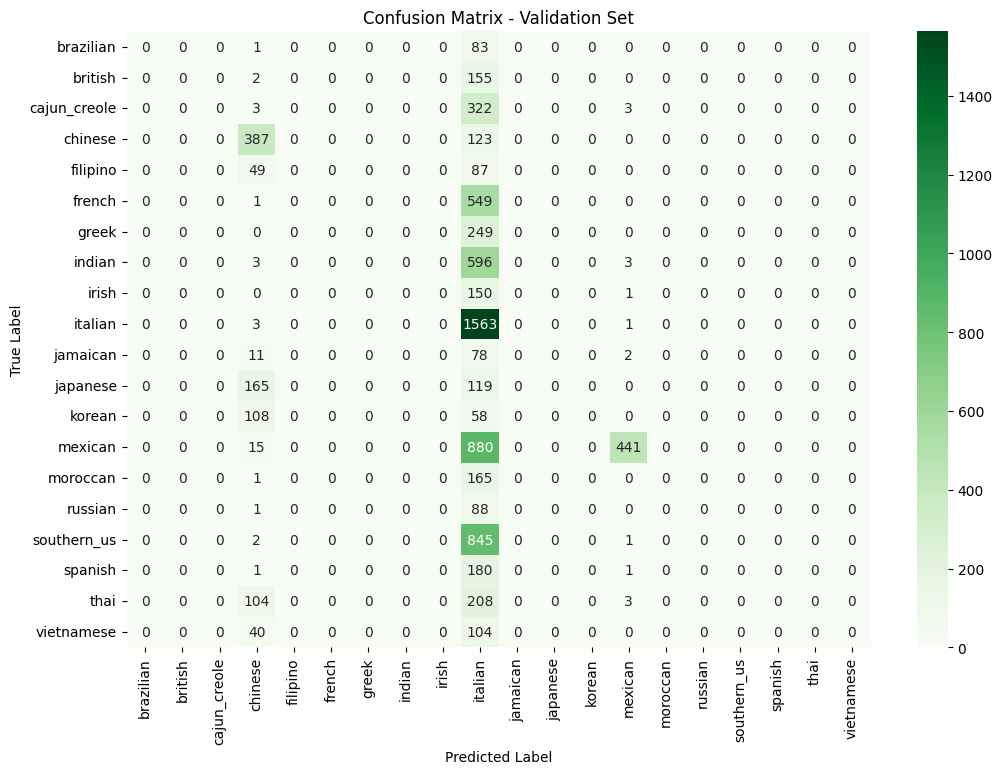

In [33]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight



train = pd.read_json(r'/train.json')
test = pd.read_json(r'/test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())


df_new=df['ingredients']

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])

vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)

from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators=120,learning_rate=0.01, random_state=0)
model.fit(X_train_vectorized, df['cuisine'])

val_predictions = model.predict(X_val_vectorized)


val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")


conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

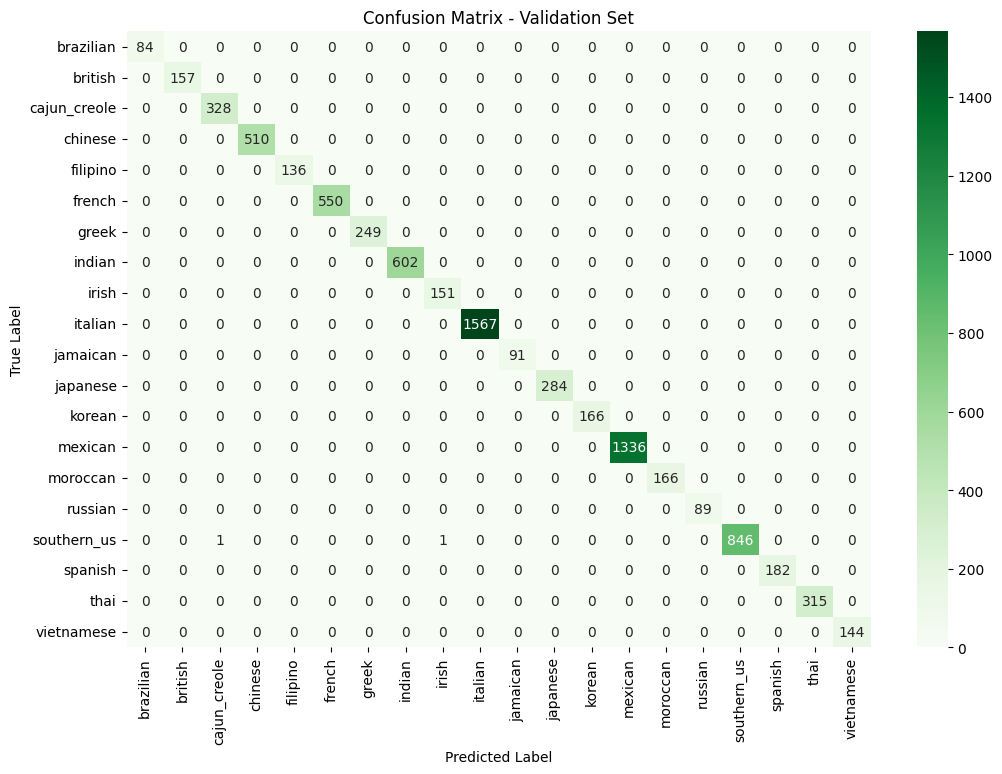

In [36]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight



train = pd.read_json(r'/train.json')
test = pd.read_json(r'/test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())


df_new=df['ingredients']

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])

vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)

from sklearn import tree

model = tree.DecisionTreeClassifier()
model.fit(X_train_vectorized, df['cuisine'])

val_predictions = model.predict(X_val_vectorized)

val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)
tree.plot_tree(model,max_depth=5)
print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")


conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [47]:
!pip install --user xgboost


import catboost as cb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


from xgboost import XGBClassifier


combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])

vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_lab= le.fit_transform(df['cuisine'])
y_vect = vectorizer.fit_transform(df['cuisine'])

X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)

model = XGBClassifier(use_label_encoder=True, eval_metric='logloss')
model.fit(X_train_vectorized, y_lab)

val_predictions = model.predict(X_val_vectorized)


val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[09:20:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




ValueError: Feature shape mismatch, expected: 3122, got 20

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

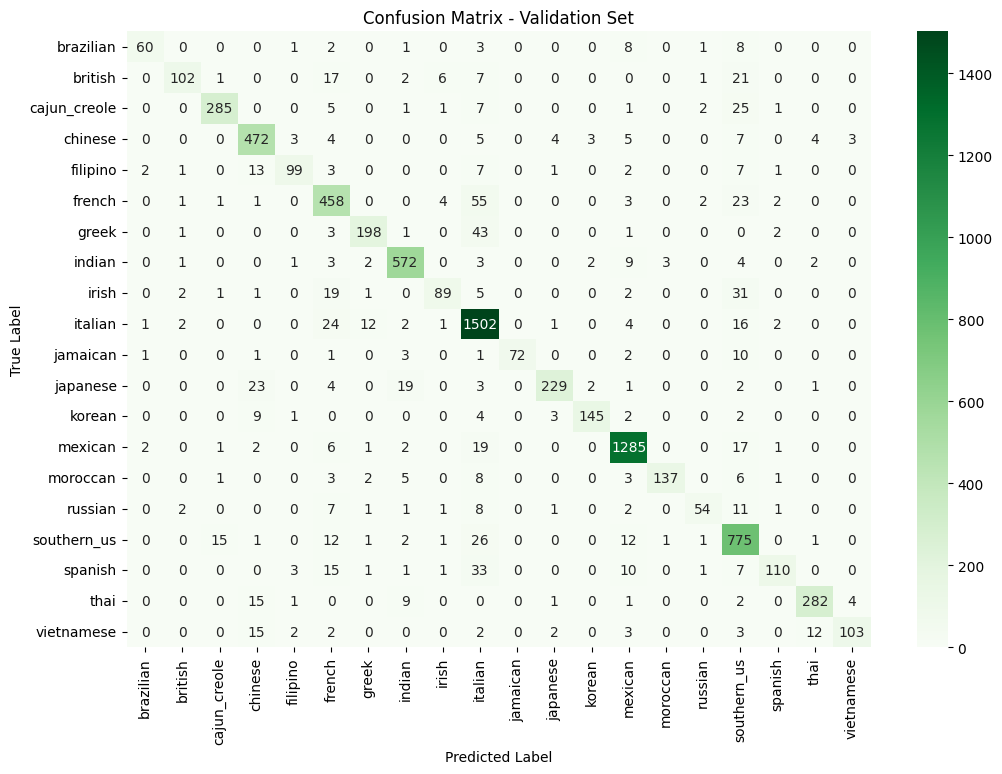

In [50]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight



train = pd.read_json(r'/train.json')
test = pd.read_json(r'/test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())


df_new=df['ingredients']

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])

vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)


from sklearn import svm

model = svm.SVC()
model.fit(X_train_vectorized, df['cuisine'])

val_predictions = model.predict(X_val_vectorized)

val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")


conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [52]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight



train = pd.read_json(r'/train.json')
test = pd.read_json(r'/test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())


df_new=df['ingredients']

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])

vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)


!pip install lightgbm
import lightgbm as lgb

model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=100)
model.fit(X_train_vectorized, df['cuisine'])

val_predictions = model.predict(X_val_vectorized)


val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")


conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



TypeError: Expected np.float32 or np.float64, met type(int64)

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.




Classification Report:
              precision    recall  f1-score   support

   brazilian       0.00      0.00      0.00        84
     british       0.00      0.00      0.00       157
cajun_creole       0.00      0.00      0.00       328
     chinese       0.00      0.00      0.00       510
    filipino       0.00      0.00      0.00       136
      french       0.00      0.00      0.00       550
       greek       0.00      0.00      0.00       249
      indian       0.00      0.00      0.00       602
       irish       0.00      0.00      0.00       151
     italian       0.20      1.00      0.33      1567
    jamaican       0.00      0.00      0.00        91
    japanese       0.00      0.00      0.00       284
      korean       0.00      0.00      0.00       166
     mexican       0.00      0.00      0.00      1336
    moroccan       0.00      0.00      0.00       166
     russian       0.00      0.00      0.00        89
 southern_us       0.00      0.00      0.00       848
   

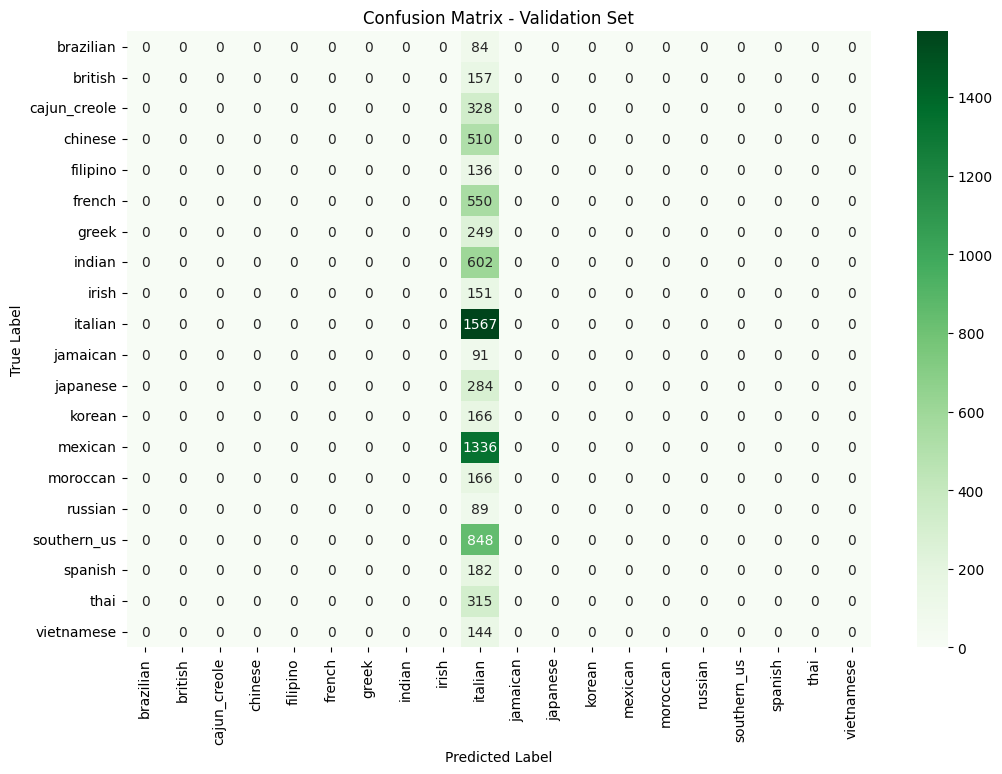

In [54]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight



train = pd.read_json(r'/train.json')
test = pd.read_json(r'/test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())


df_new=df['ingredients']

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])

vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)


from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy="most_frequent")
model.fit(X_train_vectorized, df['cuisine'])

val_predictions = model.predict(X_val_vectorized)


val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")


conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

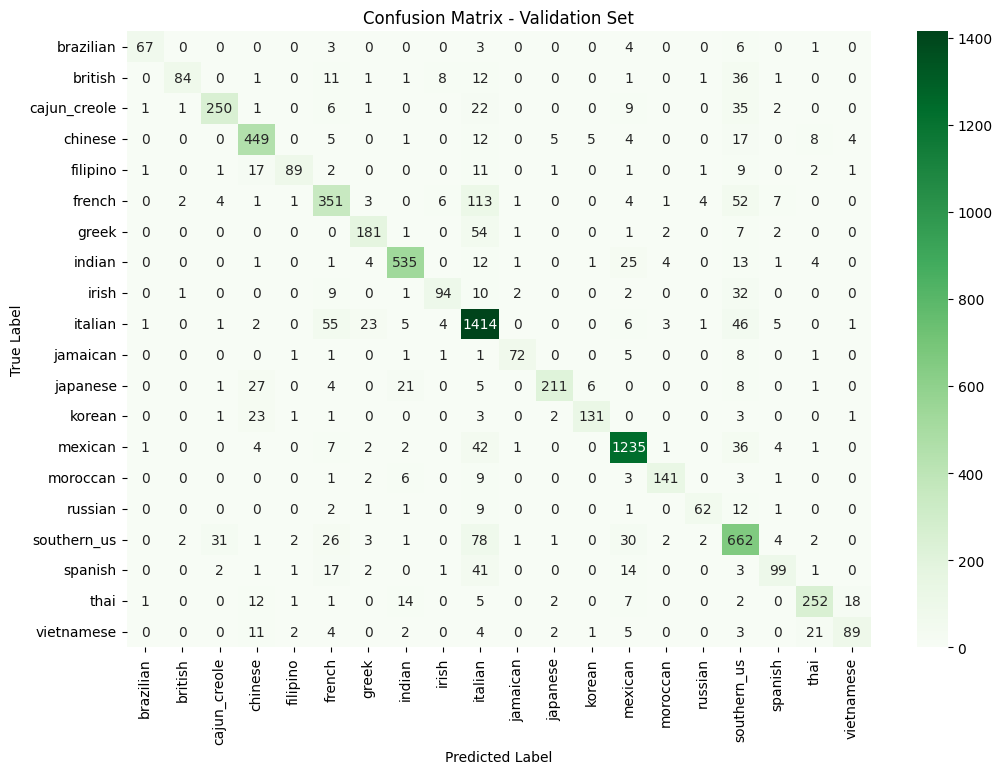

In [56]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

from sklearn.utils.class_weight import compute_class_weight



train = pd.read_json(r'/train.json')
test = pd.read_json(r'/test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())


df_new=df['ingredients']

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])

vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)



from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=0)
model.fit(X_train_vectorized, df['cuisine'])

val_predictions = model.predict(X_val_vectorized)

val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score gradbusting: {accuracy:.2f}")


conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

      id      cuisine                                        ingredients
0  10259        greek  [romaine lettuce, black olives, grape tomatoes...
1  25693  southern_us  [plain flour, ground pepper, salt, tomatoes, g...
2  20130     filipino  [eggs, pepper, salt, mayonaise, cooking oil, g...
3  22213       indian                [water, vegetable oil, wheat, salt]
4  13162       indian  [black pepper, shallots, cornflour, cayenne pe...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           39774 non-null  int64 
 1   cuisine      39774 non-null  object
 2   ingredients  39774 non-null  object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB
None
cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        

Выходные данные были обрезаны до нескольких последних строк (5000).
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-68-75b6cf003192>:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-68-75b6cf003192>:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-68-75b6cf003192>:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

------------------------------------------------------------------------------------
['blackolives', 'fetacheesecrumbles', 'garbanzobeans', 'garlic', 'grapetomatoes', 'pepper', 'purpleonion', 'romainelettuce', 'seasoning']
['eggs', 'greentomatoes', 'groundblackpepper', 'groundpepper', 'milk', 'plainflour', 'salt', 'thyme', 'tomatoes', 'vegetableoil', 'yellowcornmeal']
['butter', 'chickenlivers', 'cookingoil', 'eggs', 'garlicpowder', 'greenchilies', 'grilledchickenbreasts', 'mayonaise', 'pepper', 'salt', 'soysauce', 'yellowonion']
['salt', 'vegetableoil', 'water', 'wheat']
['bayleaf', 'blackpepper', 'bonelesschickenskinlessthigh', 'butter', 'cayennepepper', 'chilipowder', 'cornflour', 'doublecream', 'garammasala', 'garlicpaste', 'groundcumin', 'lemonjuice', 'milk', 'naturalyogurt', 'oil', 'onions', 'passata', 'salt', 'shallots', 'water']
[LibSVM]Validation Loss: 0.10
Accuracy Score: 0.91

Classification Report:
              precision    recall  f1-score   support

   brazilian       0.

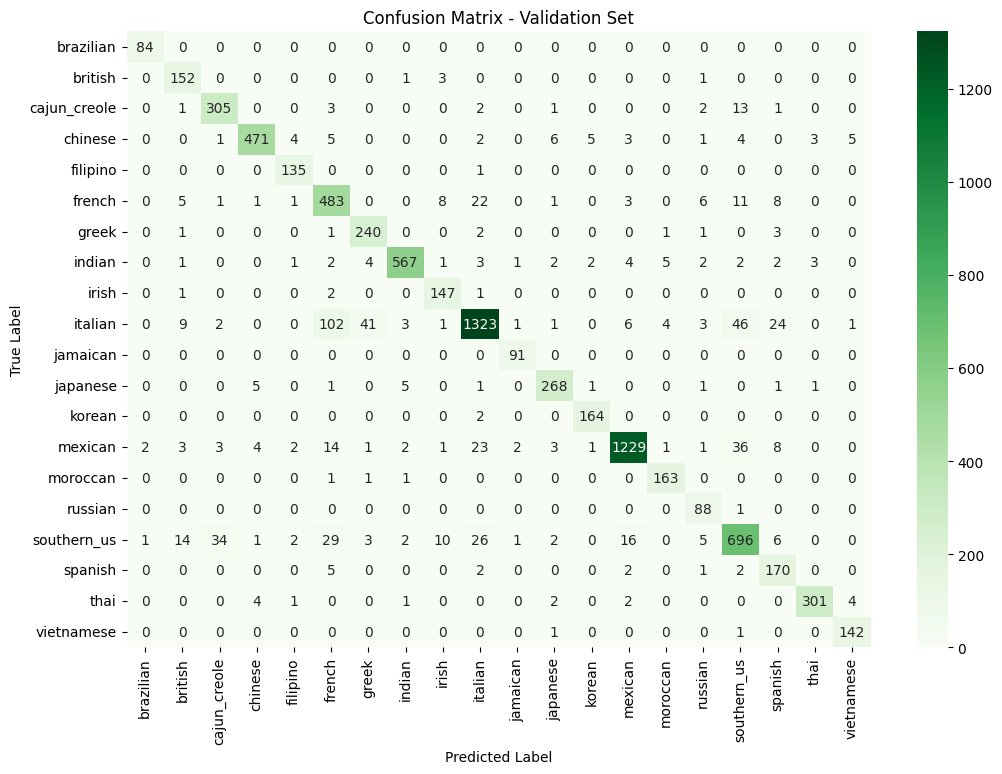

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LinearRegression
train = pd.read_json(r'/train.json')
test = pd.read_json(r'/test.json')

df=train

print(df.head())
print(df.info())

print(df['cuisine'].value_counts())

count =0
count_in=0
df_new=df['ingredients']
for i in df['ingredients']:
    count_in=0
    i_new=i
    for x in i :
        x=x.replace(" ","")
        i_new[count_in]=x
        if(count_in<len(i_new)):
           count_in= count_in +1
    i_new.sort()
    df_new[count]=i_new
    if (count< len(df_new)):
        count =count +1

print("------------------------------------------------------------------------------------")
for i in df_new.head():
    print(i)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

combined_data = pd.concat([df_new.apply(lambda x: ' '.join(x)), test['ingredients'].apply(lambda x: ' '.join(x))])

vectorizer = CountVectorizer()
combined_data_vectorized = vectorizer.fit_transform(combined_data)
X_train_vectorized = combined_data_vectorized[:len(df)]
X_test_vectorized = combined_data_vectorized[len(df):]


X_train, X_val, y_train, y_val = train_test_split(df_new.apply(lambda x: ' '.join(x)), df['cuisine'], test_size=0.2, random_state=42)
X_val_vectorized = vectorizer.transform(X_val)


model = SVC( kernel='rbf',class_weight='balanced', random_state=111, verbose=True)
model.fit(X_train_vectorized, df['cuisine'])

from sklearn.frozen import FrozenEstimator
calibrator = CalibratedClassifierCV(FrozenEstimator(model),method='isotonic')
calibrator.fit(X_train_vectorized, df['cuisine'])

val_predictions = calibrator.predict(X_val_vectorized)



val_losses = model.score(X_val_vectorized, y_val)
accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Loss: {1 - val_losses:.2f}")
print(f"Accuracy Score: {accuracy:.2f}")


conf_matrix = confusion_matrix(y_val, val_predictions)
class_report = classification_report(y_val, val_predictions)

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()